In [1]:
%matplotlib inline
from __future__ import print_function
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets
import pandas as pd
import numpy as np
import heatmap as hm
import matplotlib.pyplot as plt

In [2]:
ivis = hm.IVIS()
ivis.gt_df.head()

,eventid,year,country,region,latitude,longitude,attacktype,casualties,wounds
0,197000000001,1970,Dominican Republic,Central America & Caribbean,18.456792,-69.951164,Assassination,1.0,0.0
1,197000000002,1970,Mexico,North America,19.432608,-99.133207,Hostage Taking (Kidnapping),0.0,0.0
2,197001000001,1970,Philippines,Southeast Asia,15.478598,120.599741,Assassination,1.0,0.0
3,197001000002,1970,Greece,Western Europe,37.983773,23.728157,Bombing/Explosion,NaN,NaN
4,197001000003,1970,Japan,East Asia,33.580412,130.396361,Facility/Infrastructure Attack,NaN,NaN


In [3]:
#kind of similar to what I have in the dot plot notebook - 
#do I want to make this a function?

In [4]:
ivis.gt_df.describe()

C:\Users\Caroline\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


,eventid,year,latitude,longitude,casualties,wounds
count,1.567720e+05,156772.000000,152253.000000,152253.000000,147827.000000,142572.000000
mean,2.000541e+11,2000.474083,23.190988,24.210467,2.359237,3.089926
std,1.298283e+09,12.982397,19.220723,59.900831,11.421270,22.722313
min,1.970000e+11,1970.000000,-53.154613,-176.176447,0.000000,0.000000
25%,1.989082e+11,1989.000000,NaN,NaN,NaN,NaN
50%,2.005071e+11,2005.000000,NaN,NaN,NaN,NaN
75%,2.013060e+11,2013.000000,NaN,NaN,NaN,NaN
max,2.015123e+11,2015.000000,74.633553,179.366667,1500.000000,5500.000000


In [5]:
bubble_chart_features = ['year', 'country', 'region', 'casualties']

gtd_bubble = ivis.gt_df[bubble_chart_features]

In [6]:
gtd_bubble.describe()

C:\Users\Caroline\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


,year,casualties
count,156772.000000,147827.000000
mean,2000.474083,2.359237
std,12.982397,11.421270
min,1970.000000,0.000000
25%,1989.000000,NaN
50%,2005.000000,NaN
75%,2013.000000,NaN
max,2015.000000,1500.000000


In [7]:
#change to use Viola's make_five_year_range (add 5 to hers)?

def create_range(series_to_group, group_size):
    '''Turns a series into groups of a specified size'''
    bins = np.arange(min(series_to_group) - group_size, max(series_to_group) + group_size, group_size)
    ranges = pd.cut(series_to_group, bins)
    ranges.name = series_to_group.name + ' ranges'
    return ranges

In [9]:
def replace_series_with_range(data, series_to_group, group_size):
    '''Removes year column and merges range column'''
    ranges = create_range(series_to_group, group_size)
    data_replaced = pd.concat([data, pd.DataFrame(ranges)], axis = 1).drop(series_to_group.name, 1)
    return data_replaced

gtd_bubble.head()

,year,country,region,casualties
0,1970,Dominican Republic,Central America & Caribbean,1.0
1,1970,Mexico,North America,0.0
2,1970,Philippines,Southeast Asia,1.0
3,1970,Greece,Western Europe,NaN
4,1970,Japan,East Asia,NaN


In [10]:
gtd_bubble = replace_series_with_range(gtd_bubble, gtd_bubble['year'], 5)
gtd_bubble.head()

,country,region,casualties,year ranges
0,Dominican Republic,Central America & Caribbean,1.0,"(1965, 1970]"
1,Mexico,North America,0.0,"(1965, 1970]"
2,Philippines,Southeast Asia,1.0,"(1965, 1970]"
3,Greece,Western Europe,NaN,"(1965, 1970]"
4,Japan,East Asia,NaN,"(1965, 1970]"


In [12]:
#Need to update dot plot with these functions

In [13]:
def group_by_columns(data, group_by_columns, column_to_agg):
    '''Takes a list of column names and a column to count and counts rows by those column name, including nulls'''
    all_columns = group_by_columns + [column_to_agg]
    data.loc[:, column_to_agg] = data.loc[:, column_to_agg].fillna(value=0)
    data = data.loc[:,all_columns]
    grouped = data.groupby(group_by_columns)
    return grouped

In [14]:
def sum_by_groups(grouped):
    '''Takes output of group function and sums data'''
    sums = grouped.sum().dropna()
    sums.columns = ['sum']
    return sums

In [15]:
def count_by_groups(grouped):
    '''Takes output of group function and counts data'''
    counts = grouped.count().dropna()
    counts.columns = ['count']
    return counts

In [16]:
#Need to deal with error handling for all this stuff
class Bubble_Chart_Data():
    def __init__(self, data, bubble_id, color, user_filter, values):
        '''Defines attributes of the bubble chart'''
        self.data = data
        self.bubble_id = bubble_id
        self.color = color
        self.user_filter = user_filter
        self.values = values
        self.new_data = data
        self.groups = group_by_columns(self.data, [self.bubble_id], self.values)
        self.subgroups = group_by_columns(self.data, [self.bubble_id, self.color, self.user_filter], self.values)
    
    def count_by_subgroup(self):
        '''Uses group from init function to create a count'''
        return count_by_groups(self.subgroups)
        
    def sum_by_subgroup(self):
        '''Uses sum from init function to create a sum'''
        return sum_by_groups(self.subgroups)
    
    def aggregate_by_subgroup(self):
        '''Returns sum and count merged together'''
        self.new_data = pd.concat((self.count_by_subgroup(), self.sum_by_subgroup()), axis=1, join='outer')
        self.new_data.columns = ['attacks', 'total ' + self.values]
        self.new_data.reset_index(level=self.color, inplace=True)
        
    def count_by_group(self):
        '''Returns the sum by groups (ignores user filters)'''
        return count_by_groups(self.groups)
    
    def set_bubble_size(self, bubble_size, new_col_name):
        '''bubble size must be a series with the bubble_id as the index'''
        #want to be able to input a new column name when you do this
        self.new_data = pd.DataFrame(bubble_size).join(self.new_data, how='inner')
        #self.new_data.columns 
        self.bubble_size = new_col_name #currently assumes 1 column
        
    def add_color_dict(self):
        '''Creates a dictionary that maps the color variable to numbers'''
        #You can call this whenever without error, but once you aggregate again, the column will disappear
        #http://stackoverflow.com/questions/14885895/color-by-column-values-in-matplotlib
        color_cats = self.new_data[self.color].unique()
        colors = np.linspace(0, 1, len(color_cats))
        colordict = dict(zip(color_cats, colors))  
        self.new_data['color'] = self.new_data[self.color].apply(lambda x: colordict[x])
        
    def filter_for_user(self, user_input):
        '''Selects the part of the data that the user selected'''
        #This assumes you've already run agg by bubbleID, should also handle key error
        self.new_data = self.new_data.loc[(slice(None), user_input), :]

In [17]:
bubble_chart = Bubble_Chart_Data(gtd_bubble, 'country', 'region', 'year ranges', 'casualties')

In [18]:
bubble_chart.aggregate_by_subgroup()

In [19]:
bubble_chart.set_bubble_size(bubble_chart.count_by_group(), 'All-Time Attacks')

In [20]:
bubble_chart.new_data.head()

count      region  attacks  total casualties
country     year ranges                                               
Afghanistan (1970, 1975]   9690  South Asia      1.0               0.0
            (1975, 1980]   9690  South Asia      3.0              53.0
            (1985, 1990]   9690  South Asia     24.0             150.0
            (1990, 1995]   9690  South Asia     81.0             144.0
            (1995, 2000]   9690  South Asia     29.0             120.0

In [21]:
def process_bubble_chart_data():
    bubble_chart = Bubble_Chart_Data(gtd_bubble, 'country', 'region', 'year ranges', 'casualties')
    bubble_chart.aggregate_by_subgroup()
    bubble_chart.set_bubble_size(bubble_chart.count_by_group(), 'all-time attacks')
    bubble_chart.add_color_dict()
    return bubble_chart
    
def select_bubble_chart_year(year_range, bubble_chart):
    bubble_chart.filter_for_user(year_range)
    return bubble_chart


In [22]:
bubble_chart = process_bubble_chart_data()

bubble_chart = select_bubble_chart_year('(2010, 2015]', bubble_chart)

bubble_chart.new_data.head()

,,count,region,attacks,total casualties,color
country,year ranges,,,,,
Afghanistan,"(2010, 2015]",9690,South Asia,7077.0,20359.0,0.000000
Albania,"(2010, 2015]",77,Eastern Europe,7.0,1.0,0.090909
Algeria,"(2010, 2015]",2720,Middle East & North Africa,107.0,214.0,0.181818
Argentina,"(2010, 2015]",804,South America,6.0,0.0,0.545455
Armenia,"(2010, 2015]",22,Central Asia,3.0,0.0,0.636364


In [23]:
def construct_interval(year):
    return '('+ str(year - 5) + ', ' + str(year) + ']'

In [31]:
import seaborn as sns

def create_bubble_chart(year):
    
    bubble_chart = process_bubble_chart_data()
    
    select_bubble_chart_year(construct_interval(year), bubble_chart)
    
    plt.figure()

    plt.scatter(bubble_chart.new_data['attacks'], bubble_chart.new_data['total casualties'],bubble_chart.new_data['count']/10, c = bubble_chart.new_data['color'], alpha = 0.5)

    plt.show()

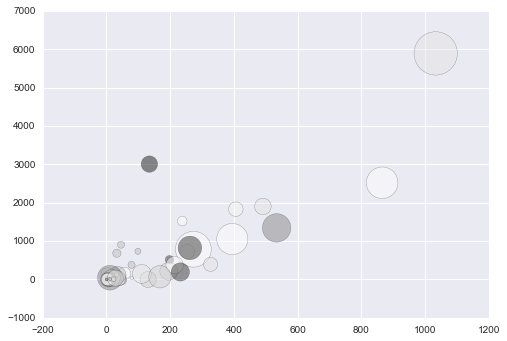

In [32]:
create_bubble_chart(2005)

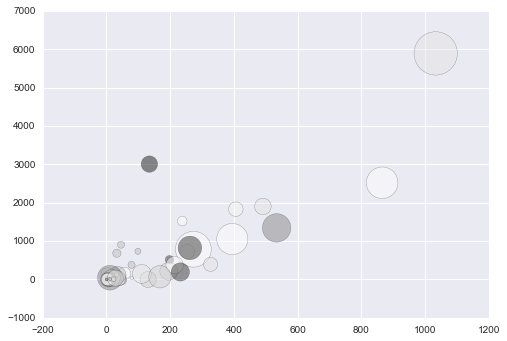

In [30]:
interact(create_bubble_chart, year=widgets.IntSlider(min=1975,max=2015,step=5,value=2015))

Also considered doing a bubble chart where the x axis is percentage change in # killed, y axis is percentage change in # attacks, and size of bubble is # incidents

Next step might be scroll-over labels, b/c I think that would be really helpful

In [27]:
#this is useful in general, don't make it specific to bubble chart
def create_total(to_sum, sum_by):
    '''takes two series of the same length, sums one by the other, returns a series with the result'''
    data = pd.concat([sum_by, to_sum], axis = 1)
    totaled = pd.pivot_table(data, index = sum_by.name, aggfunc=sum)
    totaled.columns = ['total ' + to_sum.name]
    return pd.Series(totaled['total ' + to_sum.name])